<a href="https://colab.research.google.com/github/shahad-jeza/kaust_training/blob/main/NN_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# quick pytorch overview

In [2]:
import torch
import numpy as np
import time

In [3]:
# convert from numpy array to tensor
x = np.random.rand(4,5)
print(type(x))
x = torch.from_numpy(x)
print(type(x))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [4]:
# list to tensor
x = [[1,2] , [3,4]]
print(type(x))
x = torch.Tensor(x)
print(type(x))

<class 'list'>
<class 'torch.Tensor'>


In [5]:
x = torch.randn(3,4)
print(x)

tensor([[-0.9005, -0.5958,  1.4475,  0.2175],
        [ 2.0548, -0.2956, -0.6476,  1.1970],
        [-0.1657, -0.8856,  0.4887,  1.0280]])


In [6]:
# take dervtive of y in respect to x
x = torch.Tensor([4])
x.requires_grad = True
y=x**2
y.backward()
print(x.grad)

tensor([8.])


In [7]:
# the diffrence of matrix multiplication speed

x = torch.randn(1000 , 1000)
y = torch.randn(1000 , 1000)

z = torch.zeros(1000,1000)

start = time.time()
for i in range(x.shape[0]):
  for j in range(y.shape[1]) :
    z[i,j] = torch.dot(x[i,:] , y[: , j])

end = time.time()

print(f"it took : {end-start} with nested for loop ")


start = time.time()
z = torch.mm(x,y)

end = time.time()

print(f"it took : {end-start} with pytorch matrix multiplication")



x = x.to("cuda:0")
y = y.to("cuda:0")
start = time.time()
z = torch.mm(x,y)

end = time.time()

print(f"it took : {end-start} with GPU")


it took : 23.393713235855103 with nested for loop 
it took : 0.03282785415649414 with pytorch matrix multiplication
it took : 0.09340620040893555 with GPU




---



# Example of NN using pytorch on MNIST dataset

In [8]:
import torch.nn as nn # stands for neural network
import torch.optim as optim # for optmization
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader # for data batching
import torch.nn.functional  as F


In [9]:
train_dataset = MNIST("/" , download= True , train = True , transform=T.ToTensor())
test_dataset = MNIST("/" , download= True , train = False , transform=T.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 163907177.67it/s]

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 84769554.81it/s]


Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47797330.86it/s]

Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18787503.72it/s]


Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw



In [10]:
batch_size = 32
train_loader = DataLoader(train_dataset , batch_size = batch_size)
test_loader = DataLoader(test_dataset , batch_size = batch_size)

In [11]:
# check a batch of the data
batch = next(iter(train_loader))
print(batch[0].shape)
print((batch[0].view(-1,28*28)).shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


In [12]:
class My_NN(nn.Module):
  def __init__(self , ni , nh ,no):
    super().__init__() # intilize the parents
    self.layer1 = nn.Linear(ni , nh)
    self.layer2 = nn.Linear(nh , no)

  def forward(self , x):
    x = self.layer1(x)
    x = torch.sigmoid(x)
    x = self.layer2(x)
    return x

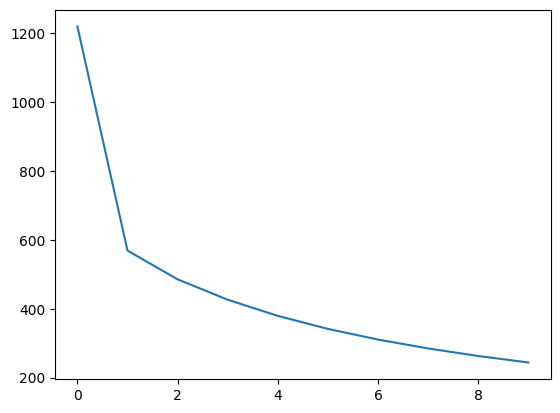

In [13]:
device = torch.device("cuda:0")
num_epochs =10
lr = 0.05
momentum = 0.5
ni = 28*28
nh = 100
no =10 # for the 10 digits
net = My_NN(ni , nh , no).to(device) # the nn is dfined now

## define optmizer
opt = optim.SGD(net.parameters() , lr=lr , momentum = momentum )

ls = []
# training loop
for i in range(num_epochs):
  total_loss =0
  for batch in train_loader:
    X,y = batch[0].view(-1,ni).to(device) , batch[1].to(device)  # extract X and y and reashape the input to be in columns
    out = net(X) # call the forward method
    loss = F.cross_entropy(out ,y) # compute loss ,have a soft max implemented
    opt.zero_grad() # clears the gradints buffers because in batch
    loss.backward() # calculate gradients and store in buffers
    opt.step() # take a step in the negtive gradient direction
    total_loss += loss.item()
  ls.append(total_loss)

plt.plot(ls)

# testing

In [14]:
from sklearn.metrics import accuracy_score

total_accuracy = 0.0
num_batches = len(test_loader)

for batch_idx, (X, y) in enumerate(test_loader):
    X = X.view(-1, ni).to(device)
    y = y.to(device)
    out = net(X)
    yhat = torch.argmax(out, dim=1).cpu().numpy()  # Convert yhat to numpy array
    y = y.cpu().numpy()  # Convert y to numpy array
    accuracy = accuracy_score(y, yhat)
    total_accuracy += accuracy

final_accuracy = total_accuracy / num_batches
print(f"The final accuracy is {final_accuracy}")

The final accuracy is 0.9600638977635783
